In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve,confusion_matrix, matthews_corrcoef, accuracy_score, precision_score, recall_score

In [2]:
def labeling(subset): #function that etiquettes the sequences if they present the signal peptide (SP) +, if not -, building a binary list

    label=[] #list of 1 if the seq is + or 0 if the seq is neg

    subset['positive/negative'] =np.where(subset['SP cleavage']=='False', '-','+')
    for row,seq in subset.iterrows():
        if seq['positive/negative']=="+":
            label.append(1)
        else:
            label.append(0)
    return label

In [3]:
subset_list=['subset1_arricchito.tsv','subset2_arricchito.tsv','subset3_arricchito.tsv','subset4_arricchito.tsv','subset5_arricchito.tsv'] #reading the 5 subset files 
subset={} #creating a dictionary whose keys will be the subset file names and the values Pandas dataframes
for i in range(len(subset_list)):
    subset[f'subset_{i+1}']=pd.read_csv(subset_list[i],sep="\t")

FileNotFoundError: [Errno 2] No such file or directory: 'subset1_arricchito.tsv'

In [ ]:
list_labels=[] #in order to prevent further errors like the following "found input variables with inconsistent numbers of samples: [1603, 1605]" we create a new dictionary with the subsets shifted
subset_for_labels = {'subset_1':subset['subset_4'],'subset_2':subset['subset_5'],'subset_3':subset['subset_1'],'subset_4':subset['subset_2'],'subset_5':subset['subset_3']}
for df in subset_for_labels.values():
    etiq = labeling(df)
    list_labels.append(etiq)

In [ ]:
def file_set_creator(subset_dict):
    """
    This function takes in input a dictionary of Pandas Dataframes and cycles through the length of the dictionary
    creating at each iteration a training_list (3 subsets of positive sequences concatenated), 1 validation list (positive and negative
    sequences) and 1 testing list (positive and negative sequences to test the model)
    """
    training_list = []
    validation_list = []
    testing_list = []
    keys = list(subset_dict.keys())   # elenco delle chiavi: ["subset_1", ..., "subset_5"]
    n = len(keys)

    for i in range(n):
        # --- Training: 3 DataFrame
        training_keys = [keys[i % n], keys[(i+1) % n], keys[(i+2) % n]]
        training_dfs = [subset_dict[k] for k in training_keys]
        training = pd.concat(training_dfs, ignore_index=True)
        pos_seq = []

        positive_df = training[training['SP cleavage'] != 'False']
    
        for _, row in positive_df.iterrows():
            sequence = row["Sequence"]
            cleavage = int(row["SP cleavage"])
            # estraggo la porzione di interesse
            pos_seq.append(sequence[cleavage-13:cleavage+2])
        
        training_list.append(pos_seq)


        # --- Validation: 1 DataFrame
        validation_key = keys[(i+3) % n]
        validation = subset_dict[validation_key]
        seq_val_90=[]
        for index,row in validation.iterrows(): 
            sequence=row["Sequence"]
            seq_val_90.append(sequence[:90])
        validation_list.append(seq_val_90)
        

        # --- Testing: 1 DataFrame
        testing_key = keys[(i+4) % n]
        testing = subset_dict[testing_key]
        seq_test_90=[]
        for index,row in testing.iterrows(): 
            sequence=row["Sequence"]
            seq_test_90.append(sequence[:90])
        testing_list.append(seq_test_90)

        

    return training_list,validation_list,testing_list

In [ ]:
trainingset,validationset,testingset = file_set_creator(subset)

In [ ]:
def init_matrix (window): #function that initialise the PSPM matrix, with pseudocounts. 
    aminoacids = ["A","R","N","D","C","Q","E","G","H","I",
              "L","K","M","F","P","S","T","W","Y","V"]
    dict_mat = {}
    for i in aminoacids:
        dict_mat[i]= [1 for i in range(window)]
    return dict_mat

In [ ]:
def compute_pswm (matrix,list_seq): #function that used the PSPM matrix and a list of sequences and computes the PSWM. Built as a dictionary of lists
    diz_swp = {'A':0.08, 'R':0.06, 'N':0.04, 'D':0.06, 'C':0.01, 'Q':0.04, 'E':0.07, 'G':0.07, 'H':0.02, 'I':0.06, 'L':0.10, 'K':0.06, 'M':0.02, 'F':0.04, 'P':0.05, 'S':0.07, 'T':0.05, 'W':0.01, 'Y':0.03, 'V':0.07} #frequency of residues from SwissProt
    for seq in list_seq:
        for index,res in enumerate(seq):
          if res not in matrix: #if residues different from the ones in the SwissFreq dictionary appear, they are skipped
              continue
          matrix[res][index]+=1
    
    div = int(len(list_seq))+20

    
    for key in matrix:
        matrix[key] = [np.log2(x/(div*diz_swp[key])) for x in matrix[key]]

    return matrix

In [ ]:
def score_window(matrix, seq_window):
    """
    It's the function that calculates the position-specific score of an amino acid window with respect to the PSWM (Position-Specific Weight Matrix) —
    it's then used to slide across the entire sequence and find the point with the highest score, which most likely corresponds to the signal peptide region.
    """
    score = 0 # Initialize the total score to zero,this will accumulate the sum
    for pos in range(len(seq_window)):
        letter = seq_window[pos]
        if letter in matrix:
            # Add the corresponding weight from the PSWM for this amino acid
            # at the specific position to the running total score
            score += matrix[letter][pos]
    return score


In [ ]:
def train_and_score(training, validation):
    # Access global labels for validation sequences
    global current_labels

    # Initialize and build the PSWM from the training set
    matrix = init_matrix(15)
    PSWM = compute_pswm(matrix, training)

    final_score = []

    # Score each validation sequence
    for seq in validation:
        if len(seq) < 15:
            continue
        scores_seq = [
            score_window(PSWM, seq[i:i + 15])
            for i in range(len(seq) - 14)
        ]
        final_score.append(max(scores_seq))

    # Evaluate performance on validation data
    precision, recall, thresholds = precision_recall_curve(current_labels, final_score)
    fscore = (2 * precision * recall) / (precision + recall) #F1-score
    optimal_threshold = thresholds[np.argmax(fscore)]

    return PSWM, optimal_threshold


In [ ]:
PSWM_matrix_final = {} #trained PSWM for each subset
optimal_threshold = {} #best threshold for each subset

for i in range(len(trainingset)): #executing the train and score function for each subset
    current_labels = list_labels[i]
    PSWM_matrix_final[f"PSWM_matrix{i}"], optimal_threshold[f"optimal_threshold{i}"] = train_and_score(trainingset[i], validationset[i])


In [ ]:
def testing(matrix, th, testing_set):
    """
    Calculates the maximum PSWM score (using 15-aa windows) for each sequence 
    in the testing set and classifies them based on a threshold.
    Returns:
        final_score: list of maximum scores per sequence
        y_pred_test: list of binary predictions (1 if score >= threshold, else 0)
    """
    final_score = []

    # Iterate over each sequence in the testing set (~90 amino acids each)
    for seq in testing_set:
        # Skip sequences shorter than the 15-aa window
        if len(seq) < 15:
            continue

        scores_seq = []
        # Slide a 15-aa window across the sequence
        for i in range(len(seq) - 14):
            window = seq[i:i + 15]                # extract 15-aa subsequence
            score = score_window(matrix, window)  # compute PSWM score for this window
            scores_seq.append(score)

        # Keep the maximum score found in the sequence
        max_score = max(scores_seq)
        final_score.append(max_score)

    # Generate binary predictions: 1 if score ≥ threshold, else 0
    y_pred_test = [int(s >= th) for s in final_score]

    # Return both the raw scores and their binary predictions
    return final_score, y_pred_test


In [ ]:
# Dictionaries to store the test results for each subset
final_score_test = {}
y_pred_test = {}

# Iterate through each of the 5 testing subsets (cross-validation folds)
for i in range(5):
    # Retrieve the PSWM matrix and optimal threshold corresponding to the current subset
    matrix = PSWM_matrix_final[f'PSWM_matrix{i}']
    th     = optimal_threshold[f'optimal_threshold{i}']

    # Get the testing sequences for this subset
    subset_testing = testingset[i]

    # Apply the PSWM to the testing set and compute:
    #   fs → list of maximum scores per sequence
    #   yp → list of binary predictions based on threshold
    fs, yp = testing(matrix, th, subset_testing)

    # Store the results for the current subset in dictionaries
    final_score_test[f'final_score_test_{i}'] = fs
    y_pred_test[f'y_pred_test_{i}']           = yp


In [ ]:
list_labels=[] #as before, in order to prevent further errors like the following "found input variables with inconsistent numbers of samples: [1603, 1605]" we create a new dictionary with the subsets shifted
subset_for_labels = {'subset_1':subset['subset_5'],'subset_2':subset['subset_1'],'subset_3':subset['subset_2'],'subset_4':subset['subset_3'],'subset_5':subset['subset_4']}
for df in subset_for_labels.values():
    etiq = labeling(df)
    list_labels.append(etiq)


Subset 0
MCC = 0.679
Precision = 0.710
Accuracy = 0.938
Sensitivity = 0.718
Confusion Matrix:
 [[1378   51]
 [  49  125]]

Subset 1
MCC = 0.679
Precision = 0.776
Accuracy = 0.941
Sensitivity = 0.651
Confusion Matrix:
 [[1397   33]
 [  61  114]]

Subset 2
MCC = 0.682
Precision = 0.735
Accuracy = 0.940
Sensitivity = 0.697
Confusion Matrix:
 [[1386   44]
 [  53  122]]

Subset 3
MCC = 0.658
Precision = 0.755
Accuracy = 0.938
Sensitivity = 0.634
Confusion Matrix:
 [[1393   36]
 [  64  111]]

Subset 4
MCC = 0.585
Precision = 0.671
Accuracy = 0.924
Sensitivity = 0.586
Confusion Matrix:
 [[1379   50]
 [  72  102]]


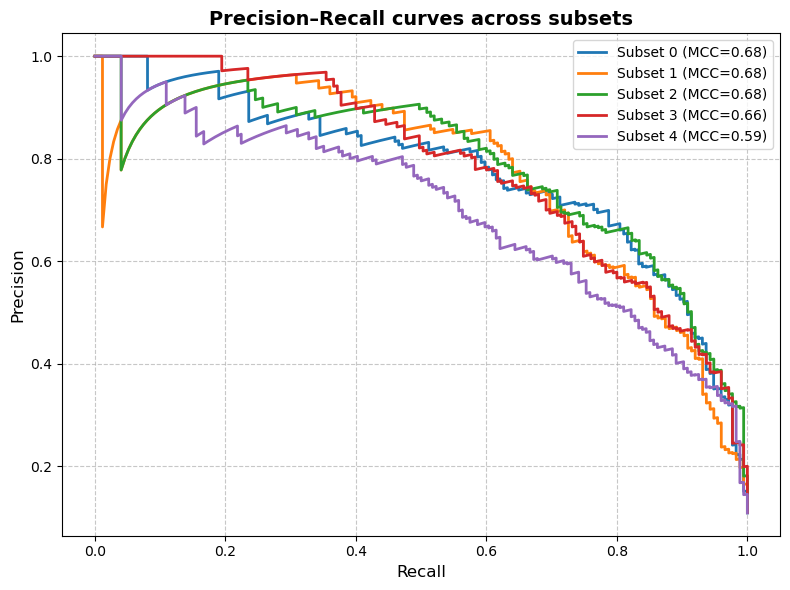

In [ ]:
# dictionaries with results
final_score_test = {}
y_pred_test = {}
y_true_test = {}
mcc_dict = {}

#loop for everysubset
for i in range(5):
    print(f"\nSubset {i}")
    matrix = PSWM_matrix_final[f'PSWM_matrix{i}']
    threshold = optimal_threshold[f'optimal_threshold{i}']
    testing_set = testingset[i]
    labels_test = list_labels[i]

    # funzione testing
    final_score, y_pred = testing(matrix, threshold, testing_set)
    final_score_test[f'final_score_test_{i}'] = final_score
    y_pred_test[f'y_pred_test_{i}'] = y_pred
    y_true_test[f'y_true_test_{i}'] = labels_test

    # metrics
    mcc = matthews_corrcoef(labels_test, y_pred)
    prec = precision_score(labels_test, y_pred)
    acc = accuracy_score(labels_test, y_pred)
    sens = recall_score(labels_test, y_pred)
    cm = confusion_matrix(labels_test, y_pred)
    mcc_dict[i] = mcc

    print(f"MCC = {mcc:.3f}")
    print(f"Precision = {prec:.3f}")
    print(f"Accuracy = {acc:.3f}")
    print(f"Sensitivity = {sens:.3f}")
    print("Confusion Matrix:\n", cm)

    # dark heatmaps
    plt.style.use("dark_background")
    df_matrix = pd.DataFrame(matrix).T
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df_matrix,
        annot=True,
        fmt=".2f",
        cmap="magma",
        center=0,
        linewidths=0.4,
        linecolor='gray',
        annot_kws={"size": 8, "color": "white", "weight": "bold"},
        cbar_kws={'label': 'Log2-Frequency'}
    )
    plt.title(f"Heatmap PSWM Matrix {i}", fontsize=16, fontweight="bold", pad=15, color="white")
    plt.xlabel("Position", fontsize=12, labelpad=8, color="white")
    plt.ylabel("Amino Acid", fontsize=12, labelpad=8, color="white")
    plt.xticks(fontsize=10, rotation=0, color="white")
    plt.yticks(fontsize=10, color="white")
    plt.tight_layout()
    plt.savefig(f"./Plots/heatmap_pswm_matrix_{i}_dark.png", dpi=300, bbox_inches="tight")
    plt.close()
    plt.style.use("default")  

    # PR curve (normal)
    prec_curve, rec_curve, thr_curve = precision_recall_curve(labels_test, final_score)
    plt.figure(figsize=(6, 5))
    plt.plot(rec_curve, prec_curve, label="PR curve", color="royalblue", linewidth=2)
    best_thr_idx = min(range(len(thr_curve)), key=lambda j: abs(thr_curve[j] - threshold))
    plt.scatter(
        rec_curve[best_thr_idx],
        prec_curve[best_thr_idx],
        color='red', s=80, label=f"Best thr = {threshold:.3f}"
    )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall curve with best threshold")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"./Plots/pr_curve_subset_{i}.png", dpi=300)
    plt.close()

# cumulative graph (normal)
plt.figure(figsize=(8, 6))
for i in range(5):
    labels_test = y_true_test[f'y_true_test_{i}']
    final_score = final_score_test[f'final_score_test_{i}']
    prec_curve, rec_curve, _ = precision_recall_curve(labels_test, final_score)
    plt.plot(rec_curve, prec_curve, label=f"Subset {i} (MCC={mcc_dict[i]:.2f})", linewidth=2)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall curves across subsets", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("./Plots/all_pr_curves.png", dpi=300)
plt.show()
